In [1]:

import glob
import os
import shutil

import numpy as np
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
from pipeline.python.utils import convert_range
import scipy.stats as spstats


from pipeline.python.utils import natural_keys, label_figure
from pipeline.python import utils as putils

import traceback
from pipeline.python.retinotopy import utils as ret_utils
from pipeline.python.rois import utils as roi_utils
import json
import tifffile as tf
from scipy import ndimage


import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.colors as mcolors
import cPickle as pkl
import h5py

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/do_retinotopy_analysis.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    a

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/rois/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/hom

In [2]:
%matplotlib notebook

# Select dataset

In [3]:
rootdir = '/n/coxfs01/2p-data'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

animalid = 'JC084' #'JC085'
session = '20190522' #'20190626'
fov = 'FOV1_zoom2p0x'
retinorun = 'retino_run2'
data_identifier = '|'.join([animalid, session, fov, retinorun])


# Set output dirs

In [4]:
outdir = os.path.join(aggr_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(outdir):
    os.makedirs(outdir)
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy'

# Select colormap

In [5]:
reload(ret_utils)
reload(putils)

<module 'pipeline.python.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/utils.pyc'>

In [6]:
# Load colormap
colormap = 'nic_Edge'
cmapdir = os.path.join(aggr_dir, 'colormaps')
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap_phase = LinearSegmentedColormap.from_list('my_colormap', cdata[::-1])

    

('min/max:', -60, 60)


<IPython.core.display.Javascript object>


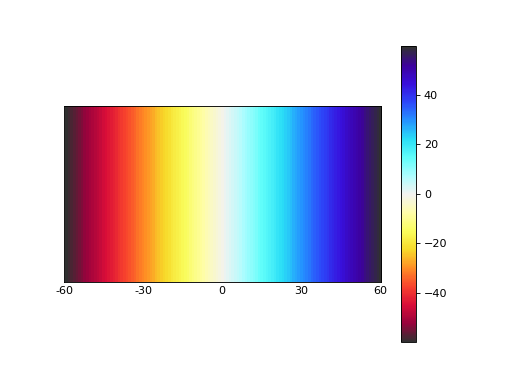

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'azimuth_pos_nic_Edge_LEGEND_abs')
('min/max:', -60, 60)


<IPython.core.display.Javascript object>


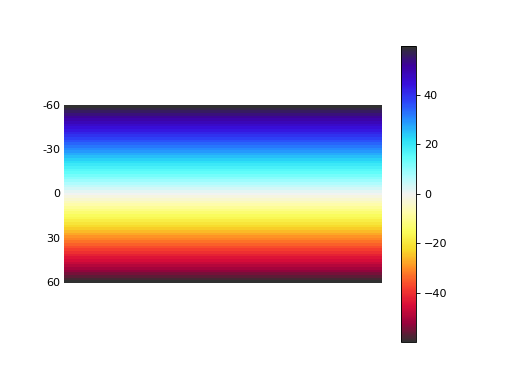

(67, 120)
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'elevation_pos_nic_Edge_LEGEND_abs')


In [7]:
zero_center = True
screen = ret_utils.make_legends(cmap=cmap_phase, cmap_name=colormap, zero_center=zero_center, outdir=outdir)

# Get retino run info

In [8]:
def load_mw(run_dir):
    print("... loading paradigm info")
    paradigm_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', 'parsed_trials*.json'))[0]
    with open(paradigm_fpath, 'r') as r: mwinfo = json.load(r)
    return mwinfo


In [9]:
def plot_example_traces(soma_traces, np_traces, rid=0, cond='right',
                       soma_color='k', np_color='r', ax=None):
    
    if ax is None:
        fig, ax = pl.subplots()
    ax.plot(soma_traces[cond][rid], soma_color, label='soma')
    ax.plot(np_traces[cond][rid], np_color, label='neuropil')
    
    return ax

In [17]:
traceid = 'traces001'

run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
RETID = ret_utils.load_retinoanalysis(run_dir, traceid)
analysis_dir = RETID['DST']
retinoid = RETID['analysis_id']
print("Loaded: %s, %s (%s))" % (retinorun, retinoid, run_dir))

data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
print("data ID: %s" % data_id)

# Load MW info and SI info
mwinfo = load_mw(run_dir)
scaninfo = ret_utils.get_protocol_info(animalid, session, fov, run=retinorun) # load_si(run_dir)
tiff_paths = tiff_fpaths = sorted(glob.glob(os.path.join(RETID['SRC'], '*.tif')), key=natural_keys)
print("Found %i tifs" % len(tiff_paths))

# avgtraces = retinoutils.get_condition_averaged_traces(RETID, analysis_dir, mwinfo, scaninfo, tiff_paths, create_new=False)
# avgtraces.keys()
trials_by_cond = scaninfo['trials']
for k, v in trials_by_cond.items():
    print("...%s: %i reps" % (k, len(v)))
    
# Set current animal's retino output dir
curr_dst_dir = os.path.join(analysis_dir, 'retino-structure')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)


Corresponding ANALYSIS ID (for traces001 with rois001) is: analysis002
{   u'DST': u'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_7e9e1a',
    u'PARAMS': {   u'average_frames': u'5',
                   u'downsample_factor': u'2',
                   u'excluded_tiffs': [],
                   u'hashid': u'adfbb4',
                   u'minus_rolling_mean': True,
                   u'rid_hash': u'efa39d',
                   u'roi_id': u'rois001',
                   u'roi_type': u'manual2D_circle',
                   u'signal_channel': 1,
                   u'smooth_fwhm': None,
                   u'tiff_source': u'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/processed/processed001_5827fc/mcorrected_8d0461'},
    u'SRC': u'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/processed/processed001_5827fc/mcorrected_8d0461',
    u'analysis_hash': u'7e9e1a',
    u'analysis_id': u'analysis002'}
Loaded: retino_run2, analysis002 (/n

In [18]:
print("Saving current output to:\n %s" % curr_dst_dir)

Saving current output to:
 /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_7e9e1a/retino-structure


# Process raw traces

In [12]:
# Some preprocessing params
temporal_ds = float(RETID['PARAMS']['average_frames'])
print("Temporal ds: %.2f" % (temporal_ds))

#### Load raw dataa
retino_dpath = os.path.join(analysis_dir, 'traces', 'extracted_traces.h5')

#### Process traces -- returns average trace for condition
np_traces = ret_utils.load_retino_traces(retino_dpath, scaninfo, trace_type='neuropil', temporal_ds=temporal_ds)
soma_traces = ret_utils.load_retino_traces(retino_dpath, scaninfo, trace_type='raw', temporal_ds=temporal_ds)


Temporal ds: 5.00
... loading cond: top
Performing temporal smoothing on traces...
... loading cond: right
Performing temporal smoothing on traces...
... loading cond: left
Performing temporal smoothing on traces...
... loading cond: bottom
Performing temporal smoothing on traces...
... loading cond: top
Performing temporal smoothing on traces...
... loading cond: right
Performing temporal smoothing on traces...
... loading cond: left
Performing temporal smoothing on traces...
... loading cond: bottom
Performing temporal smoothing on traces...


# Do fft

In [13]:
n_frames = scaninfo['stimulus']['n_frames']
frame_rate = scaninfo['stimulus']['frame_rate']
stim_freq_idx = scaninfo['stimulus']['stim_freq_idx']

#### label frequency bins
freqs = np.fft.fftfreq(n_frames, float(1./frame_rate))
sorted_freq_idxs = np.argsort(freqs)


fft_soma = dict((cond, ret_utils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) for cond, tdf in soma_traces.items())
fft_np = dict((cond, ret_utils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) for cond, tdf in np_traces.items())


In [14]:
mag_thr=0.01 #if trace_type == 'neuropil' else 0.02
all_conds_pass = True

# Get average magratios & filter responsive cells
# -------------------------------------------------------------

# Create dataframe of magratios -- each column is a condition
magratios_soma = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_soma.items()))
phases_soma = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_soma.items()))

magratios_np = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_np.items()))
phases_np = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_np.items()))

# Get average across conditions
mean_magratio_values_soma = magratios_soma.mean(axis=1).values 
mean_magratio_values_np = magratios_np.mean(axis=1).values

# Sort ROIs by their average mag ratios
sorted_rois_soma = np.argsort(mean_magratio_values_soma)[::-1]
# for roi in sorted_rois_soma[0:10]:
#     print(roi, mean_magratio_values_soma[roi], mean_magratio_values_np[roi])

# Filter out bad cells
if all_conds_pass:
    roi_list = [i for i in magratios_soma.index if all(magratios_soma.loc[i] >= mag_thr)]
else:
    roi_list = magratios_soma.index.tolist()
print("%i out of %i cells pass mag-ratio thr (thr>=%.2f)" % (len(roi_list), len(mean_magratio_values_soma), mag_thr))
sorted_by_mag = [r for r in sorted_rois_soma if r in roi_list]

178 out of 260 cells pass mag-ratio thr (thr>=0.01)


#### Look at example cell

In [15]:
sorted_rois_soma[0:5]

array([178,  66, 141, 236, 208])

<IPython.core.display.Javascript object>


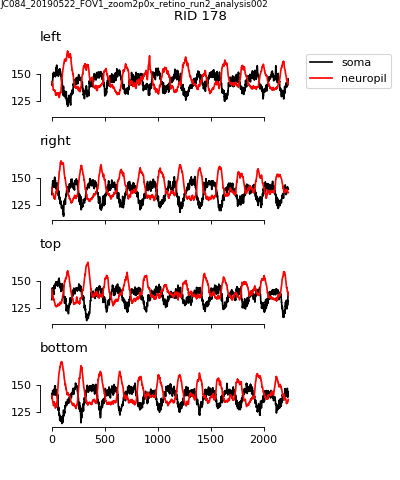

<IPython.core.display.Javascript object>


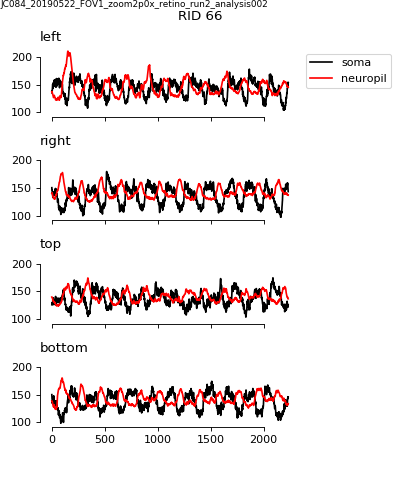

<IPython.core.display.Javascript object>


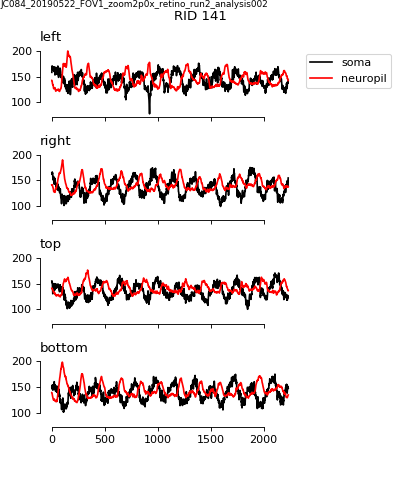

In [19]:
rid = 178 #113

save_plot = True
if save_plot:
    if not os.path.exists(os.path.join(curr_dst_dir, 'example_traces')):
        os.makedirs(os.path.join(curr_dst_dir, 'example_traces'))
        
for rid in sorted_rois_soma[0:3]:
    fig, axn = pl.subplots(4, 1, sharex=True, sharey=True, figsize=(5, 6))
    for ai, (ax, cond) in enumerate(zip(axn.flat, ['left', 'right', 'top', 'bottom'])):
        ax = plot_example_traces(soma_traces, np_traces, rid=rid, cond=cond, ax=ax)
        if ai==0:
            ax.legend(bbox_to_anchor=(1, 1))
        ax.set_title(cond, loc='left', fontsize=12)

    pl.subplots_adjust(left=0.1, right=0.75, hspace=0.5, top=0.9)
    sns.despine(trim=True)

    pl.suptitle('RID %i' % rid)
    label_figure(fig, data_id)

    if save_plot:
        pl.savefig(os.path.join(curr_dst_dir, 'example_traces', 'np_v_soma_roi%05d.png' % int(rid+1)))

# Get mask info

In [20]:
def load_roi_masks(RETID):

    # Get ROIID and projection image
    roiid = RETID['PARAMS']['roi_id']
    ds_factor = int(RETID['PARAMS']['downsample_factor'])
    

    zimg = ret_utils.load_fov_image(RETID)
    d1, d2 = zimg.shape

    # Get roi extraction info
    session_dir = RETID['DST'].split('FOV')[0]
    rid_fpath = glob.glob(os.path.join(session_dir, 'ROIs', 'rids*.json'))[0]
    with open(rid_fpath, 'r') as f:
        rids = json.load(f)
    reffile = rids[roiid]['PARAMS']['options']['ref_file']

    # Load masks
    retino_dpath = os.path.join(RETID['DST'], 'traces', 'extracted_traces.h5')
    tfile = h5py.File(retino_dpath, 'r')

    # Reshape masks
    masks_np = tfile['File%03d' % int(reffile)]['np_masks'][:].T
    masks_soma = tfile['File%03d' % int(reffile)]['masks'][:].copy()
    print("NP masks:", masks_np.shape)

    nrois_total, _ = masks_soma.shape
    masks_np = np.reshape(masks_np, (nrois_total, d1, d2))
    masks_np[masks_np>0] = 1

    masks_soma = np.reshape(masks_soma, (nrois_total, d1, d2))
    masks_soma[masks_soma>0] = 1
    print(masks_soma.shape)

    print( tfile['File%03d' % int(reffile)].keys())
    
    return masks_soma, masks_np

In [21]:
# Get ROIID and projection image
roiid = RETID['PARAMS']['roi_id']
ds_factor = int(RETID['PARAMS']['downsample_factor'])
zimg = ret_utils.load_fov_image(RETID)
# d1, d2 = zimg.shape

masks_soma, masks_np = load_roi_masks(RETID)
nrois_total, d1, d2 = masks_soma.shape

FOV size: (256, 256) (downsample factor=2)
FOV size: (256, 256) (downsample factor=2)
('NP masks:', (260, 65536))
(260, 256, 256)
[u'corrected', u'masks', u'neuropil', u'np_masks', u'np_subtracted', u'processed', u'raw']


<IPython.core.display.Javascript object>


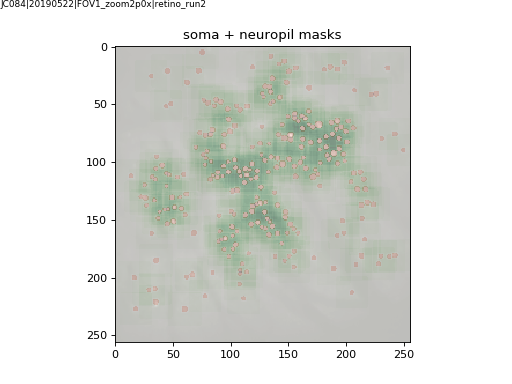

In [22]:
fig, ax = pl.subplots()
roi_utils.plot_neuropil_masks(masks_soma, masks_np, zimg, ax=ax)
ax.set_title('soma + neuropil masks')
label_figure(fig, data_identifier)
pl.savefig(os.path.join(curr_dst_dir, 'soma-v-neuropil-masks.png'))

# Dilate soma masks
From Liang et al., 2018, Cell.
1. Assign center of neuropil ring w/ preferred retino location.
2. From Neurpil ring center, dilate by a disk of 10um radius (20um diam)
3. Average overlapping disks
4. Spatially smooth w/ isotropic 2D Guassian filter (std=2um) for final pixe-wise estimates 

In [23]:
import imutils
from scipy.ndimage.morphology import binary_dilation


In [24]:
def dilate_mask_centers(maskcenters, kernel_size=9):
    '''Calculate center of soma, then dilate to create masks for smoothed  neuropil
    '''
    kernel_radius = (kernel_size - 1) // 2
    x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
    dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

    # let's create three kernels for the sake of example
    radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
    # using ... allows compatibility with arbitrarily-shaped radius arrays

    kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)# shape (num_radii, kernel_size, kernel_size)

    dilated_masks = np.zeros(maskcenters.shape, dtype=maskcenters.dtype)
    for roi in range(maskcenters.shape[0]):
        img = maskcenters[roi, :, :].copy()
        x, y = np.where(img>0)
        centroid = (sum(x) / len(x), sum(y) / len(x))
        #print(centroid)
        np_tmp = np.zeros(img.shape, dtype=bool)
        np_tmp[centroid] = True
        dilation = binary_dilation(np_tmp, structure=kernel )
        dilated_masks[roi, : :] = dilation
    return dilated_masks

def mask_rois(masks, value_array, mask_thr=0.1, return_array=False):
    nrois, d1, d2 = masks.shape
    dims = (d1, d2)

    if return_array:
        value_mask = np.ones(masks.shape)*np.nan #-100
        for rid in value_array.index.tolist():
            value_mask[rid, masks[rid,:,:]>=mask_thr] = value_array[rid]

    else:
        value_mask =  np.ones(dims)*-100
        for rid in value_array.index.tolist():
            value_mask[masks[rid,:,:]>=mask_thr] = value_array[rid]

    return value_mask



def mask_with_overlaps_averaged(dilated_masks, value_array, mask_thr=0.1):
    nrois, d1, d2 = dilated_masks.shape
    
    # Get non-averaged array
    tmpmask = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=False)
    
    # Get full array to average across overlapping pixels
    tmpmask_full = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=True)
    tmpmask_r = np.reshape(tmpmask_full, (nrois_total, d1*d2))
    
    # Replace overlapping pixels with average value
    avg_mask = tmpmask.copy().ravel()
    multi_ixs = [i for i in range(tmpmask_r.shape[-1]) if len(np.where(tmpmask_r[:, i])[0]) > 1]
    for ix in multi_ixs:
        #avg_azim[ix] = spstats.circmean([v for v in azim_phase2[:, ix] if not np.isnan(v)], low=vmin, high=vmax)
        avg_mask[ix] = np.nanmean([v for v in tmpmask_r[:, ix] if not np.isnan(v)])#, low=vmin, high=vmax)

    avg_mask = np.reshape(avg_mask, (d1, d2))

    return avg_mask

In [34]:
# measured pixel size: (2.3, 1.9)
# want to dilate by ~9.52380952381

desired_radius_um = 10.0 #20.0

pixel_size = putils.get_pixel_size()
#pixel_size = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)
print(pixel_size)
um_per_pixel = np.mean(pixel_size) / ds_factor # divide by DS factor (pixels are half if ds=2)

pixels2dilate = desired_radius_um/um_per_pixel
print(pixels2dilate)

(2.3, 1.9)
9.52380952381


(11, 11)


<IPython.core.display.Javascript object>


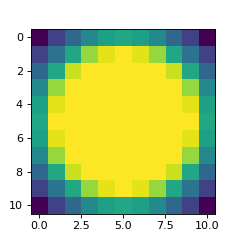

Dilation diameter (um): 11.55


<IPython.core.display.Javascript object>


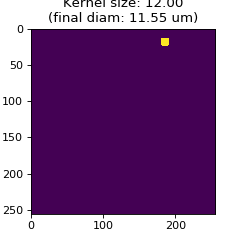

10
10


In [35]:
check_masks = True

# Set kernel params
kernel_size = np.ceil(pixels2dilate+2) #21
kernel_radius = (kernel_size - 1) // 2
x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

# Create three kernels for the sake of example
radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
# using ... allows compatibility with arbitrarily-shaped radius arrays
kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)# shape (num_radii, kernel_size, kernel_size)
print(kernel.shape)


if check_masks:
    pl.figure(figsize=(3,3))
    pl.imshow(kernel)
    kernel_diam_um = (kernel.shape[0]*um_per_pixel)
    print("Dilation diameter (um): %.2f" % kernel_diam_um)

## Dilate all masks with kernel
dilated_masks = dilate_mask_centers(masks_soma.astype(float), kernel_size=kernel_size)

if check_masks:
    rid = 33
    pl.figure(figsize=(3,3))
    pl.imshow(dilated_masks[rid, :, :])
    pl.title("Kernel size: %.2f\n(final diam: %.2f um)" % (kernel_size, kernel_diam_um))
    x, y = np.where(dilated_masks[rid, :, :]>0)
    print x.max()-x.min()
    print y.max()-y.min()


# Assign phase to neuropil

In [36]:
def get_phase_masks(masks, phases, average_overlap=True, roi_list=None, use_cont=True, mask_thr=0.01):
    # Convert phase to continuous:
    phases_cont = -1 * phases
    phases_cont = phases_cont % (2*np.pi)
    
    # Only include specified rois:
    if roi_list is None:
        roi_list = phases.index.tolist()
        
    # Get absolute maps:
    if use_cont:
        elev = (phases_cont['bottom'] - phases_cont['top']) / 2.
        azim = (phases_cont['left'] - phases_cont['right']) / 2.
        vmin = -np.pi
        vmax = np.pi
    else:
        # Get absolute maps:
        elev = (phases['bottom'] - phases['top']) / 2.
        azim = (phases['left'] - phases['right']) / 2.
        
        # Convert to continueous:
        elev_c = -1 * elev
        elev_c = elev_c % (2*np.pi)
        azim_c = -1 * azim
        azim_c = azim_c % (2*np.pi)

        vmin = 0
        vmax = 2*np.pi

        azim = copy.copy(azim_c)
        elev = copy.copy(elev_c)
        
    if average_overlap:
        azim_phase = mask_with_overlaps_averaged(masks, azim[roi_list], mask_thr=mask_thr)
        elev_phase = mask_with_overlaps_averaged(masks, elev[roi_list], mask_thr=mask_thr)
    else:
        azim_phase = mask_rois(masks, azim[roi_list], mask_thr=mask_thr)
        elev_phase = mask_rois(masks, elev[roi_list], mask_thr=mask_thr)   
    
    return azim_phase, elev_phase



In [37]:
use_cont = True
average_overlap = True
filter_by_mag = True
mask_thr=0.01

# Set bounds for averaging
vmin = -np.pi if use_cont else 0
vmax = np.pi if use_cont else 2*np.pi

# Assign phase value to dilated masks
azim_phase_np, elev_phase_np = get_phase_masks(dilated_masks, phases_np, average_overlap=average_overlap, 
                                               roi_list=None, use_cont=use_cont, mask_thr=mask_thr)

azim_phase_soma, elev_phase_soma = get_phase_masks(masks_soma, phases_soma, average_overlap=average_overlap, 
                                                   roi_list=roi_list, use_cont=use_cont, mask_thr=mask_thr)

# Mask images for plotting
azim_phase_mask_np = np.ma.masked_where(azim_phase_np==-100, azim_phase_np)
elev_phase_mask_np = np.ma.masked_where(elev_phase_np==-100, elev_phase_np)

azim_phase_mask_soma = np.ma.masked_where(azim_phase_soma==-100, azim_phase_soma)
elev_phase_mask_soma = np.ma.masked_where(elev_phase_soma==-100, elev_phase_soma)


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice


# Check resizing

#### Reshape array, if need

In [38]:
from pipeline.python.coregistration import align_fov as coreg

In [39]:
pixel_size = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)

((256, 256), (1177, 972))


<IPython.core.display.Javascript object>


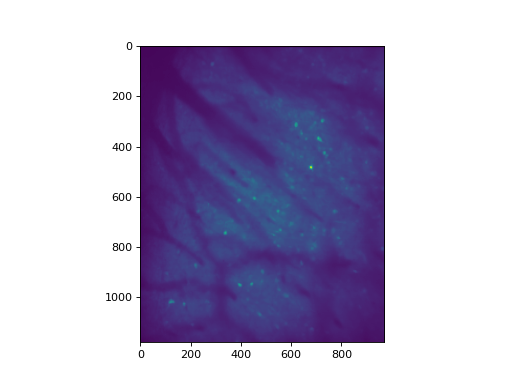

In [40]:
zimg_r = coreg.transform_2p_fov(zimg, pixel_size)
print(zimg.shape, zimg_r.shape)

pl.figure()
pl.imshow(zimg_r)

# Smooth

In [41]:
from scipy.interpolate import SmoothBivariateSpline

def fill_and_smooth_nas(img):

    y, x = np.meshgrid(np.arange(0, img.shape[1]), np.arange(0, img.shape[0]))
    x = x.astype(float)
    y = y.astype(float)
    z = img.copy()

    x[np.isnan(z)] = np.nan
    y[np.isnan(z)] = np.nan

    x=x.ravel()
    x=(x[~np.isnan(x)])
    y=y.ravel()
    y=(y[~np.isnan(y)])
    z=z.ravel()
    z=(z[~np.isnan(z)])

    xnew = np.arange(x.min(), x.max()+1) #np.arange(9,11.5, 0.01)
    ynew = np.arange(y.min(), y.max()+1) #np.arange(10.5,15, 0.01)

    f = SmoothBivariateSpline(x,y,z,kx=1,ky=1)
    znew=np.transpose(f(xnew, ynew))

    return znew.T #a


In [42]:
# Spatial smooth neuropil dilated masks 
smooth_fwhm = 7 #21
azim_smoothed = ret_utils.smooth_neuropil(azim_phase_np, smooth_fwhm=smooth_fwhm)
elev_smoothed = ret_utils.smooth_neuropil(elev_phase_np, smooth_fwhm=smooth_fwhm)

if 'zoom1p0x' in fov:
    print("... resizing")
    azim_smoothed = cv2.resize(azim_smoothed, (new_d1, new_d2))
    elev_smoothed = cv2.resize(elev_smoothed, (new_d1, new_d2))
    
azim_smoothed = fill_and_smooth_nas(azim_smoothed)
elev_smoothed = fill_and_smooth_nas(elev_smoothed)

# Transform FOV to match widefield
azim_r = coreg.transform_2p_fov(azim_smoothed, pixel_size, normalize=False)
elev_r = coreg.transform_2p_fov(elev_smoothed, pixel_size, normalize=False)
print(azim_r[~np.isnan(azim_r)].min(), azim_r[~np.isnan(azim_r)].max())

az_fill = azim_r.copy()
el_fill = elev_r.copy()
# # Fill and smooth over NaNs
# az_fill = fill_and_smooth_nas(azim_r)
# el_fill = fill_and_smooth_nas(elev_r)



(0.0, 1.4269067316229538)


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/utils.py:150: RuntimeWarning: invalid value encountered in divide
  azim_smoothed = VV/WW


<IPython.core.display.Javascript object>


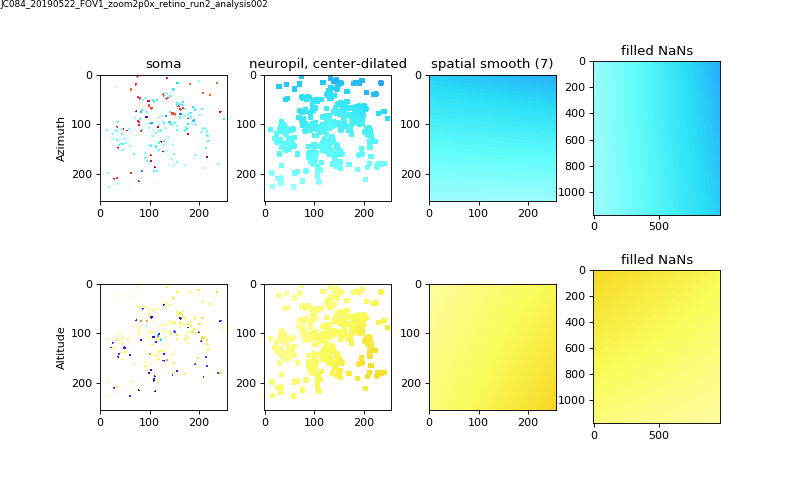

(u'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_7e9e1a/retino-structure', 'soma-v-neuropil_dilate-center-12_spatial-smooth-7')


In [43]:
fig, axn = pl.subplots(2,4, figsize=(10,6))

ax = axn[0,0]
ax.imshow(azim_phase_mask_soma, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('soma')
ax.set_ylabel('Azimuth')

ax = axn[0, 1]
ax.imshow(azim_phase_mask_np, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('neuropil, center-dilated')

ax = axn[0, 2]
ax.imshow(azim_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('spatial smooth (%i)' % smooth_fwhm)

ax = axn[0, 3]
ax.imshow(az_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')


ax = axn[1, 0]
ax.imshow(elev_phase_mask_soma, cmap=cmap_phase, vmin=vmin, vmax=vmax)
#ax.set_title('soma')
ax.set_ylabel('Altitude')

ax = axn[1, 1]
ax.imshow(elev_phase_mask_np, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 2]
ax.imshow(elev_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 3]
ax.imshow(el_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')



pl.subplots_adjust(wspace=0.3, hspace=0.3)

putils.label_figure(fig, data_id)
figname = 'soma-v-neuropil_dilate-center-%i_spatial-smooth-%i' % (kernel_size, smooth_fwhm)

pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)

#### Plot smoothed azimuth neuropil

In [44]:
# cmap = 'nipy_spectral' # cmap_phase
# overlay = True
# overlay_str = '_overlay' if overlay else ''
# alpha = 0.5 if overlay else 1.0

# fig, axn = pl.subplots(1,2)
# ax = axn[0]
# if overlay:
#     ax.imshow(zimg_r, cmap='gray')
# ax.imshow(azim_r, cmap=cmap_phase, vmin=vmin, vmax=vmax, alpha=alpha)
# ax.set_title('Azimuth')

# ax = axn[1]
# if overlay:
#     ax.imshow(zimg_r, cmap='gray')
# ax.imshow(elev_r, cmap=cmap_phase, vmin=vmin, vmax=vmax, alpha=alpha)
# ax.set_title('Altitude')

# figname = 'smoothed_neuropil_dilate-%i_spatial-fwhm-%i%s' % (kernel_size, smooth_fwhm, overlay_str)

# pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))


# Calculate image gradient

In [45]:
def calculate_gradients(img):
    # Get gradient
    gdy, gdx = np.gradient(img)
    
    # 3) Calculate the magnitude
    gradmag = np.sqrt(gdx**2 + gdy**2)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    #scale_factor = np.max(gradmag)/255
    #gradmag = (gradmag/scale_factor).astype(np.uint8)

    # 3) Take the absolute value of the x and y gradients
    abs_gdx = np.absolute(gdx)
    abs_gdy = np.absolute(gdy)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    abs_gd = np.arctan2(gdy, gdx) # np.arctan2(abs_gdy, abs_gdx) # [-pi, pi]

    # Get mean direction
    #mean_dir = np.rad2deg(np.arctan2(gdy.mean(), gdx.mean())) # TODO why this diff
    mean_dir = np.rad2deg(spstats.circmean([np.arctan2(gy, gx) for gy, gx in zip(gdy.ravel(), gdx.ravel())],
                         low=-np.pi, high=np.pi)) # TODO why this diff

    # Get unit vector
    avg_gradient = spstats.circmean(abs_gd, low=-np.pi, high=np.pi) #.mean()
    dirvec = (np.cos(avg_gradient), np.sin(avg_gradient))
    vhat = dirvec / np.linalg.norm(dirvec)

    grad_ = {'image': img,
             'magnitude': gradmag,
             'gradient_x': gdx,
             'gradient_y': gdy,
             'direction': abs_gd,
             'mean_deg': mean_dir, # DEG
             'mean_direction': avg_gradient, # RADIANS
             'vhat': vhat}
    
    return grad_


def plot_gradients(grad_, ax=None, draw_interval=3, scale=1, width=0.005, toy=False, headwidth=5):
    '''
    scale:  # of dat units per arrow length unit (smaller=longer arrow)
    scale_units 
    weight = width of plot
    angles='xy' (i.e., arrows point from (x,y) to (x+u, y+v))
    Arrows should point TOWARD larger numbers
    '''
    if ax is None:
        fig, ax = pl.subplots()
        
    gradimg = grad_['image']
    mean_dir = grad_['mean_deg']
    gdx = grad_['gradient_x']
    gdy = grad_['gradient_y']
    
    # Set limits and number of points in grid
    y, x = np.mgrid[0:gradimg.shape[0], 0:gradimg.shape[1]]

    # Every 3rd point in each direction.
    skip = (slice(None, None, draw_interval), slice(None, None, draw_interval))
    
    # plot
    ax.quiver(x[skip], y[skip], gdx[skip], gdy[skip], color='k',
              scale=scale, width=width,
              scale_units='xy', angles='xy', pivot='mid', units='width',
              headwidth=headwidth)

    avg_dir_grad = np.rad2deg(grad_['direction'].mean())
    ax.set(aspect=1, title="Mean: %.2f\n(dir: %.2f)" % (mean_dir, avg_dir_grad))

    return ax

#### Test w/ toy example

In [46]:
# Create some images going in various directions
gradimg = np.ones((60, 30))
for i in range(30):
    gradimg[:, i] = gradimg[:, i]*(i**2)*0.01
gradimg = gradimg.astype(float)
gradimg_lr = np.fliplr(gradimg.copy()) #gradimg.T
gradimg_ud = gradimg.copy().T
gradimg_du = np.flipud(gradimg_ud)

# Calculate gradients
grad_ = calculate_gradients(gradimg)
grad_lr = calculate_gradients(gradimg_lr)
grad_ud = calculate_gradients(gradimg_ud)
grad_du = calculate_gradients(gradimg_du)


<IPython.core.display.Javascript object>


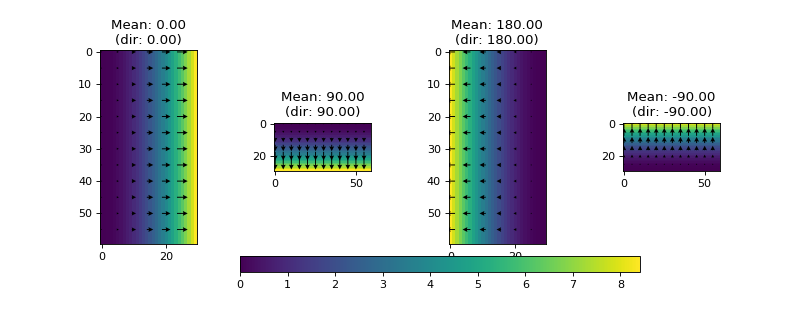

In [47]:
# Yellow = higher #s, arrows should point in direction toward higher
spacing = 5
scale=None
width=0.01
headwidth=5

fig, axn = pl.subplots(1,4, figsize=(10, 4))
cbar_ax = fig.add_axes([0.3, 0.15, 0.5, 0.05])

ax = axn[0]
ax.imshow(grad_['image'])
plot_gradients(grad_, ax=ax,draw_interval=spacing, toy=True, 
               headwidth=headwidth, scale=scale, width=width)
#ax.invert_yaxis()

ax = axn[1]
ax.imshow(grad_ud['image'])
plot_gradients(grad_ud, ax=ax, draw_interval=spacing, toy=True,
               headwidth=headwidth, scale=scale, width=width)
#ax.invert_yaxis()

ax = axn[2]
ax.imshow(grad_lr['image'])
plot_gradients(grad_lr, ax=ax, draw_interval=spacing, toy=True,
               headwidth=headwidth, scale=scale, width=width)
#ax.invert_yaxis()

ax = axn[3]
im = ax.imshow(grad_du['image'])
plot_gradients(grad_du, ax=ax, draw_interval=spacing, toy=True,
               headwidth=headwidth, scale=scale, width=width)
#ax.invert_yaxis()

pl.subplots_adjust(wspace=0.8)
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
pl.subplots_adjust(bottom=0.2)
pl.savefig(os.path.join(curr_dst_dir, 'test_gradient_dirs.png'))

## Test calculation of slope with toy ex

In [64]:
gimg = grad_['image'].copy()
d1, d2 = grad_['image'].shape
print(d1, d2)
vhat_ = grad_['vhat']

# gimg = grad_az['image'].copy()
# d1, d2 = grad_az['image'].shape
# print(d1, d2)
# vhat_ = grad_az['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))

(1177, 972)


<IPython.core.display.Javascript object>


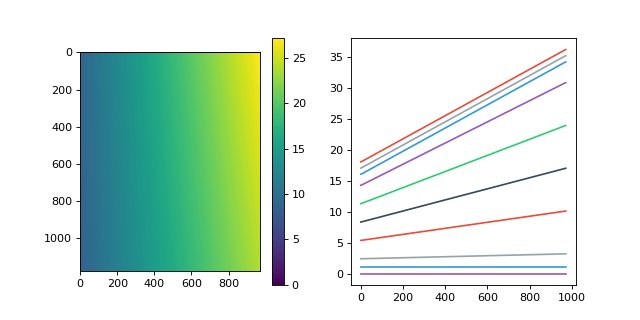

In [77]:
fig, axn =pl.subplots(1,2, figsize=(8,4))
i0 = axn[0].imshow(gimg)
pl.colorbar(i0, ax=axn[0])

ax=axn[1]

n=10
for i in np.arange(0, n):
    axn[1].plot(gimg[i,:] + i)

#### Project and test

In [74]:
proj_az = np.array([np.dot(np.array((xv, yv)), vhat_) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
pix = np.array([xv for yv in np.arange(0, d1) for xv in np.arange(0, d2) ])

ret_az = np.array([gimg[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )
coords = np.array([np.array((xv, yv)) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])

In [69]:
n=60
for c, i, v in zip(coords[0:n], proj_az[0:n], ret_az[0:n]):
    print('[%i, %i] %.2f, %.2f' % (c[0], c[1], i,v))
    
print('--------last few:')
print(coords[-5:])

[0, 0] 0.00, 0.00
[1, 0] 1.00, 0.00
[2, 0] 1.99, 0.00
[3, 0] 2.99, 0.00
[4, 0] 3.99, 0.00
[5, 0] 4.98, 0.00
[6, 0] 5.98, 0.00
[7, 0] 6.98, 0.00
[8, 0] 7.97, 0.00
[9, 0] 8.97, 0.00
[10, 0] 9.97, 0.00
[11, 0] 10.96, 0.00
[12, 0] 11.96, 0.00
[13, 0] 12.95, 0.00
[14, 0] 13.95, 0.00
[15, 0] 14.95, 0.00
[16, 0] 15.94, 0.00
[17, 0] 16.94, 0.00
[18, 0] 17.94, 0.00
[19, 0] 18.93, 0.00
[20, 0] 19.93, 0.00
[21, 0] 20.93, 0.00
[22, 0] 21.92, 0.00
[23, 0] 22.92, 0.00
[24, 0] 23.92, 0.00
[25, 0] 24.91, 0.00
[26, 0] 25.91, 0.00
[27, 0] 26.91, 0.00
[28, 0] 27.90, 0.00
[29, 0] 28.90, 0.00
[30, 0] 29.90, 0.00
[31, 0] 30.89, 0.00
[32, 0] 31.89, 0.00
[33, 0] 32.88, 0.00
[34, 0] 33.88, 0.00
[35, 0] 34.88, 0.00
[36, 0] 35.87, 0.00
[37, 0] 36.87, 0.00
[38, 0] 37.87, 0.00
[39, 0] 38.86, 0.00
[40, 0] 39.86, 0.00
[41, 0] 40.86, 0.00
[42, 0] 41.85, 0.00
[43, 0] 42.85, 0.00
[44, 0] 43.85, 0.00
[45, 0] 44.84, 0.00
[46, 0] 45.84, 0.00
[47, 0] 46.84, 0.00
[48, 0] 47.83, 0.00
[49, 0] 48.83, 0.00
[50, 0] 49.83, 0.00
[

#### plot results

<IPython.core.display.Javascript object>


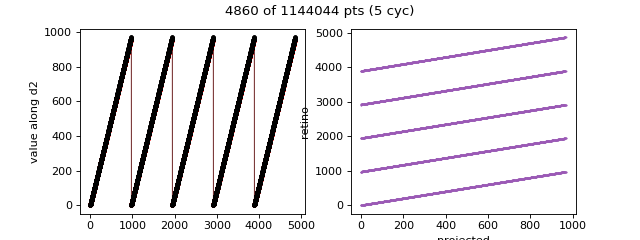

Text(0,0.5,u'retino')

In [71]:
fig, axn = pl.subplots(1,2, figsize=(8,3)) #.figure()

ncyc=5
npts = d2*ncyc
fig.suptitle("%i of %i pts (%i cyc)" % (npts, len(proj_az), ncyc))

ax = axn[0]
ax.plot(proj_az[0:npts], 'r',  marker='.', lw=0.5)
ax.plot(pix[0:npts], 'k',  marker='.', lw=.5)
#ax.plot(ret_az[0:npts], 'b', marker='.', lw=0)
ax.set_ylabel('value along d2')
ax = axn[1]
offsets = [i for i in np.arange(0, npts)]
ax.scatter(proj_az[0:npts], ret_az[0:npts]+offsets, marker='.', s=2)
ax.set_xlabel('projected')
ax.set_ylabel('retino')

<IPython.core.display.Javascript object>


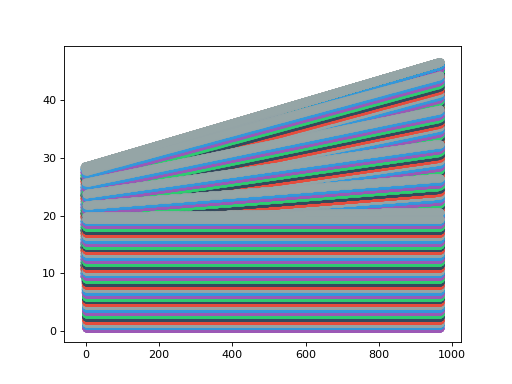

In [72]:
pl.figure()
ncyc=40
#pl.scatter(proj_az[0:d2*ncyc], ret_az[0:d2*ncyc])
for i in np.arange(1, ncyc):
    pl.scatter(proj_az[0:d2*ncyc], ret_az[0:d2*ncyc]+i*0.5)

## Calculate gradient on retino map

In [60]:
# Convert to degrees
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

In [61]:
# Calculate gradients
plot_degrees = True

if plot_degrees:
    vmin=-np.pi
    vmax=np.pi
    img_az = convert_range(az_fill, oldmin=vmin, oldmax=vmax, 
                           newmin=screen_min, newmax=screen_max)
    img_el = convert_range(el_fill, oldmin=vmin, oldmax=vmax,
                           newmin=screen_min, newmax=screen_max)
    
    grad_az = calculate_gradients(img_az)
    grad_el = calculate_gradients(img_el)
    vmin, vmax = (screen_min, screen_max)

else:
    grad_az = calculate_gradients(az_fill)
    grad_el = calculate_gradients(el_fill)
    vmin, vmax = (-np.pi, np.pi)
    
print(vmin, vmax)

(-59.7782, 59.7782)


In [62]:
#plot_degrees = True

if not plot_degrees:
    img_az = convert_range(az_fill, oldmin=vmin, oldmax=vmax, 
                           newmin=screen_min, newmax=screen_max)
    img_el = convert_range(el_fille, oldmin=vmin, oldmax=vmax,
                           newmin=screen_min, newmax=screen_max)
    vmin, vmax = (screen_min, screen_max)


<IPython.core.display.Javascript object>


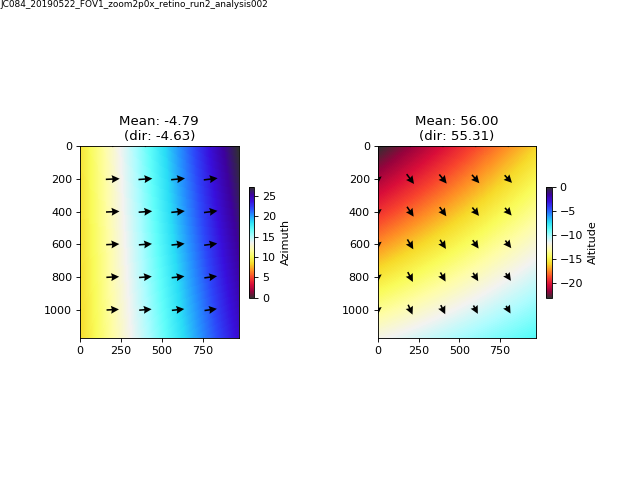

(u'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_7e9e1a/retino-structure', 'gradients_dilate-center-12_spatial-smooth-7_degrees')


In [63]:
spacing = 200
scale = None #0.0001
width = 0.01 #0.01
headwidth=5

plot_str = 'degrees' if plot_degrees else ''
fig, axn = pl.subplots(1, 2, figsize=(8,6))
ax = axn[0]
im = ax.imshow(img_az, cmap=cmap_phase)#, vmin=vmin, vmax=vmax)
plot_gradients(grad_az, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
fig.colorbar(im, ax=ax, shrink=0.3, label='Azimuth')

ax = axn[1]
im = ax.imshow(img_el,cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
plot_gradients(grad_el, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
fig.colorbar(im, ax=ax, shrink=0.3, label='Altitude')

pl.subplots_adjust(wspace=0.5, hspace=0.3)

putils.label_figure(fig, data_id)
figname = 'gradients_dilate-center-%i_spatial-smooth-%i_%s' % (kernel_size, smooth_fwhm, plot_str)

pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

0.0

In [99]:
gimg[]

(1177, 972)

## Compute unit vector and project

In [78]:

avg_dir_el = np.rad2deg(grad_el['mean_direction'])
print('[EL]avg dir: %.2f deg' % avg_dir_el)
vhat_el = grad_el['vhat']

avg_dir_az = np.rad2deg(grad_az['mean_direction'])
print('[AZ]avg dir: %.2f deg' % avg_dir_az)
vhat_az = grad_az['vhat']

print(vhat_az, vhat_el)


[EL]avg dir: 56.00 deg
[AZ]avg dir: -4.79 deg
(array([ 0.99650744, -0.08350403]), array([ 0.55921246,  0.82902438]))


<IPython.core.display.Javascript object>


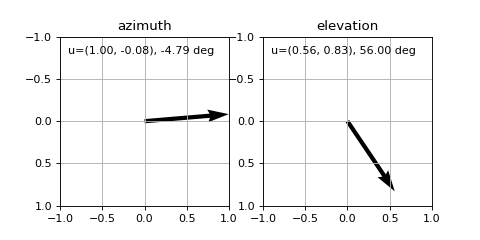

In [115]:
fig, axn = pl.subplots(1, 2, figsize=(6,3))

ax = axn[0]
ax.grid(True)
ax.set_title('azimuth')
vh = grad_az['vhat'].copy()
az_dir = np.rad2deg(np.arctan2(vh[1], vh[0])) #+ 360.) % 360
vhat_az = (np.cos(np.deg2rad(az_dir)), np.sin(np.deg2rad(az_dir)))

ax.text(-.9, -.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_az[0], vhat_az[1], az_dir))
ax.quiver(0,0, vhat_az[0], vhat_az[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

ax = axn[1]
ax.grid(True)
ax.set_title('elevation')
el_dir = np.rad2deg(np.arctan2(vhat_el[1], vhat_el[0]))
ax.text(-0.9, -0.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_el[0], vhat_el[1], el_dir))
ax.quiver(0,0, vhat_el[0], vhat_el[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

#### Test vector directions an quiver plotting...

<IPython.core.display.Javascript object>


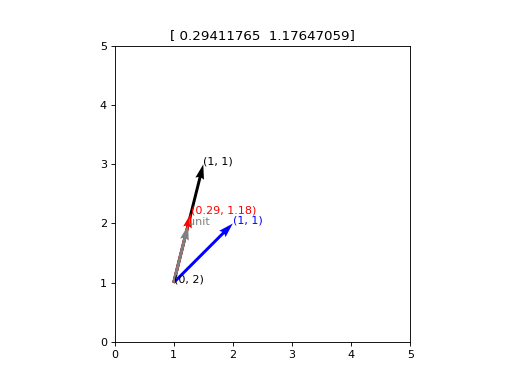

(1, 1)


Text(1.24254,1.97014,u'unit')

In [520]:

# for xi in np.arange(0, 3):
#     for yi in np.arange(0, 5):

y, x = np.mgrid[0:gimg.shape[0], 0:gimg.shape[1]]

xi=1
yi=1

fig, ax =pl.subplots()
ax.set_aspect('equal')
ax.set_ylim([0, 5])
ax.set_xlim([0, 5])
print(x[xi, yi], y[xi, yi])

v1 = np.array([0.5, 2.0])
v2 = np.array([1.0, 1.0])
vh = v1 / np.linalg.norm(v1) # unit vector

# Original vector, direction
ax.quiver(x[xi, yi], y[xi, yi], v1[0], v1[1], color='k', 
            scale=1, scale_units='xy', units='xy', angles='xy', width=.05, pivot='tail')
ax.text(x[xi, yi]+v1[0], y[xi, yi]+v1[1], '(%i, %i)' % (x[xi, yi], y[xi, yi]))
ax.text(x[xi, yi], y[xi, yi], '(%i, %i)' % (v1[0], v1[1]))

# V to be projected
ax.quiver(x[xi, yi], y[xi, yi], v2[0], v2[1], color='b',
            scale=1, scale_units='xy', units='xy', angles='xy', width=.05, pivot='tail')
ax.text(x[xi, yi]+v2[0], y[xi, yi]+v2[1], '(%i, %i)' % ( v2[0], v2[1]), color='b')

# vec projection onto original
vproj = vh * np.dot(v2, vh) 
ax.quiver(x[xi, yi], y[xi, yi], vproj[0], vproj[1], color='r',
            scale=1, scale_units='xy', units='xy', angles='xy', width=.05, pivot='tail')
ax.text(x[xi, yi]+vproj[0], y[xi, yi]+vproj[1], '(%.2f, %.2f)' % (vproj[0], vproj[1]), color='r')
ax.set_title(vproj)

# Also show unit
ax.quiver(x[xi, yi], y[xi, yi], vh[0], vh[1], color='gray',
            scale=1, scale_units='xy', units='xy', angles='xy', width=.05, pivot='tail')
ax.text(x[xi, yi]+vh[0], y[xi, yi]+vh[1], 'unit', color='gray')# % (x[xi, yi], y[xi, yi]))


## Calculate gradients and projec to get mean

In [521]:
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf

<IPython.core.display.Javascript object>


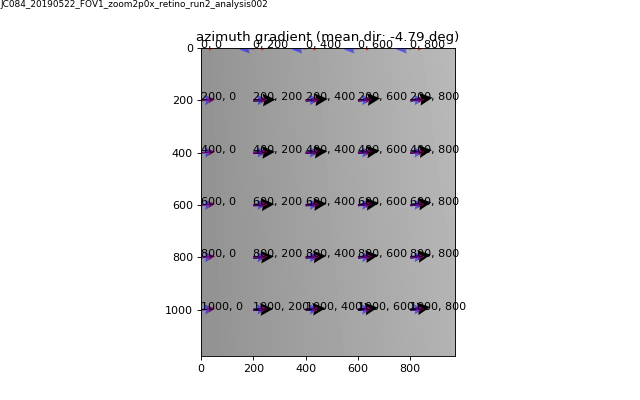

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/matplotlib/quiver.py:666: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/matplotlib/quiver.py:666: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


(u'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_7e9e1a/retino-structure', 'vhat_gradients_12_spatial-smooth-7_azimuth')


In [98]:
spacing = 200
scale = None #0.0001
width = 0.01 #0.01
headwidth=5


condition = 'azimuth'

# Set limits and number of points in grid
if condition == 'azimuth':
    gimg = grad_az['image'].copy()
    vhat = grad_az['vhat']
    gdx = grad_az['gradient_x']
    gdy = grad_az['gradient_y']
    mean_dir = np.rad2deg(grad_az['mean_direction'])

elif condition == 'elevation':
    gimg = grad_el['image'].copy()
    vhat = grad_el['vhat']
    gdx = grad_el['gradient_x']
    gdy = grad_el['gradient_y']
    mean_dir = np.rad2deg(grad_el['mean_direction'])

# Every 3rd point in each direction.
y, x = np.mgrid[0:gimg.shape[0], 0:gimg.shape[1]]
skip = (slice(None, None, spacing), slice(None, None, spacing))

# Plot image
fig, ax = pl.subplots(figsize=(8,5))
ax.imshow(gimg, vmin=vmin, vmax=vmax, cmap='gray') # #, origin='top')
ax.set(aspect=1, title='%s gradient (mean dir: %.2f deg)' % (condition, mean_dir))


# Plot all the gradients
ax.quiver(x[skip], y[skip], gdx[skip], gdy[skip], 
          color='k', scale=scale, width=width, headwidth=headwidth,
          scale_units='xy', units='width', angles='xy', pivot='tail')

# Plot unit vector at each position
ax.quiver(x[skip], y[skip], vhat[0], vhat[1], #np.array((vhat_el[1])), 
              #color='r', alpha=1, width=0.005,
              color='r', scale=scale, width=0.005, headwidth=headwidth,
              scale_units='xy', units='width', angles='xy', pivot='tail')

for xi, xv in enumerate(np.arange(0, y.shape[0], spacing)):
    for yi, yv in enumerate(np.arange(0, y.shape[1], spacing)):
        #nv = (gdx[skip][xi, yi], gdy[skip][xi, yi])
        nv = np.array([y[skip][xi, yi], x[skip][xi, yi]])
        #print(xi, yi, nv)
        # vector projection onto vhat (multiply with unit vec in direction of dirvec)
        vproj = vhat * np.dot(nv, vhat) 
        ax.text(x[skip][xi, yi], y[skip][xi, yi], '%i, %i' %(xv, yv), fontsize=10)
        
        # Plot projection
        ax.quiver(x[skip][xi, yi], 
                  y[skip][xi, yi], 
                  vproj[0], vproj[1],
                  alpha=0.5, #width=0.008,
                  color='b', scale=scale, width=0.008, headwidth=headwidth,
                  scale_units='xy', units='width', angles='xy', pivot='tail')


putils.label_figure(fig, data_id)
figname = 'vhat_gradients_%i_spatial-smooth-%i_%s' % (kernel_size, smooth_fwhm, condition)

pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)


In [110]:
gimg_az = grad_az['image'].copy()
d1, d2 = grad_az['image'].shape
print(d1, d2)
vhat_az = grad_az['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
vhat_el = grad_el['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
print(vhat_az, vhat_el)

gimg_el = grad_el['image'].copy()


(1177, 972)
(array([ 0.99650744, -0.08350403]), array([ 0.55921246,  0.82902438]))


In [111]:
proj_az = np.array([np.dot(np.array((xv, yv)), vhat_az) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
ret_az = np.array([gimg_az[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )

proj_el = np.array([np.dot(np.array((xv, yv)), vhat_el) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
ret_el = np.array([gimg_el[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )

pix = np.array([xv for yv in np.arange(0, d1) for xv in np.arange(0, d2) ])
coords = np.array([np.array((xv, yv)) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])


<IPython.core.display.Javascript object>


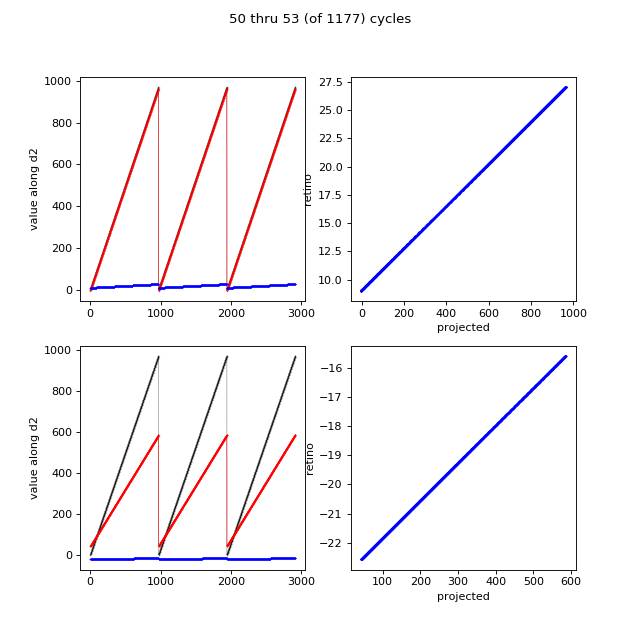

Text(0,0.5,u'retino')

In [119]:
fig, axn = pl.subplots(2,2, figsize=(8,8)) #.figure()

ncyc=3

startcyc=50
endcyc=startcyc+ncyc

npts = d2*endcyc
spts = d2*startcyc
fig.suptitle("%i thru %i (of %i) cycles" % (startcyc, endcyc, d1))

ax = axn[0,0]
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_az[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_az[spts:npts], 'b', marker='.', lw=0, markersize=0.5)

ax.set_ylabel('value along d2')
ax = axn[0,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_az[spts:npts], ret_az[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')


ax = axn[1,0]
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_el[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_el[spts:npts], 'b', marker='.', lw=0, markersize=0.5)

ax.set_ylabel('value along d2')
ax = axn[1,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_el[spts:npts], ret_el[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')

## Fit linear

In [120]:
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf

<IPython.core.display.Javascript object>


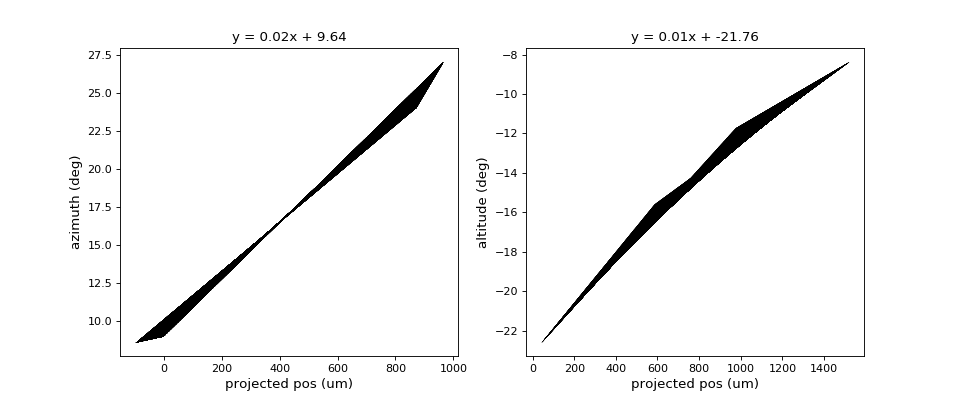

Text(0.5,0,u'projected pos (um)')

In [123]:
fitv_az, regr_az = evalrf.fit_linear_regr(proj_az, ret_az, return_regr=True)
fitv_el, regr_el = evalrf.fit_linear_regr(proj_el, ret_el, return_regr=True)

# rmse = np.sqrt(skmetrics.mean_squared_error(yv, fitv))
# r2 = skmetrics.r2_score(yv, fitv)
# pearson_p, pearson_r = spstats.pearsonr(xv, yv)

fig, axn = pl.subplots(1,2, figsize=(12, 5))

ax=axn[0]
ax.scatter(proj_az[spts:], ret_az[spts:], marker='.', lw=0, color='k', s=.2)
linfit_str = 'y = %.2fx + %.2f' % (float(regr_az.coef_), float(regr_az.intercept_)) 
ax.set_title(linfit_str)
ax.set_ylabel('azimuth (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

        
ax=axn[1]
ax.scatter(proj_el[spts:], ret_el[spts:], marker='.', lw=0, color='k', s=.2, alpha=0.5)
linfit_str = 'y = %.2fx + %.2f' % (float(regr_el.coef_), float(regr_el.intercept_)) 
ax.set_title(linfit_str)
ax.set_ylabel('altitude (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

In [ ]:
fig, axn = pl.subplots(1,2, figsize=(12, 5))

ax=axn[0]
sns.regplot(proj_az[spts:], ret_az[spts:], ax=ax) #, marker='.', lw=0, color='k', s=.2)
linfit_str = 'y = %.2fx + %.2f' % (float(regr_az.coef_), float(regr_az.intercept_)) 
ax.set_title(linfit_str)
ax.set_ylabel('azimuth (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

        
ax=axn[1]
sns.regplot(proj_el[spts:], ret_el[spts:], ax=ax) #, marker='.', lw=0, color='k', s=.2)
#ax.scatter(proj_el[spts:], ret_el[spts:], marker='.', lw=0, color='k', s=.2, alpha=0.5)
linfit_str = 'y = %.2fx + %.2f' % (float(regr_el.coef_), float(regr_el.intercept_)) 
ax.set_title(linfit_str)
ax.set_ylabel('altitude (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

<IPython.core.display.Javascript object>

In [674]:
vhat_az

(0.99650743915286322, -0.083504034112146686)

In [684]:
# d1=588
# d2=486

d1, d2 = img_az.shape
print(d1, d2)
y, x = np.mgrid[0:img_az.shape[0], 0:img_az.shape[1]]

# Project pixel positions 
proj_az=[]
proj_el=[]
ret_az=[]
ret_el=[]
for xi, xv in enumerate(np.arange(0, y.shape[0])):
    for yi, yv in enumerate(np.arange(0, y.shape[1])):
        nv = np.array([y[xi, yi], x[xi, yi]])
        #print(xi, yi, nv)
        # vector projection onto vhat (multiply with unit vec in direction of dirvec)
        vproj_a = np.dot(nv, vh) 
        proj_az.append(vproj_a)
        
        vproj_e = np.dot(nv, vhat_el) 
        proj_el.append(np.array(vproj_e))
        
        ret_az.append(np.array(img_az[xv, yv]))
        ret_el.append(np.array(img_el[xv, yv]))

proj_az = np.array(proj_az)       
proj_el = np.array(proj_el)    
ret_az = np.array(ret_az)       
ret_el = np.array(ret_el)       

# proj_az = np.array([np.dot(np.array((yv, xv)), vhat_az) for yv in np.arange(0, d2) for xv in np.arange(0, d1)])
# proj_el = np.array([np.dot(np.array((yv, xv)), vhat_el) for xv in np.arange(0, d1) for yv in np.arange(0, d2)])

# Get pixel coordinates in order of ^^
pix = np.array([yv for xv in np.arange(0, d1) for yv in np.arange(0, d2)])

(1177, 972)


In [ ]:
pl.figure()
pl.

In [688]:
vhat_az

(0.99650743915286322, -0.083504034112146686)

In [689]:
vh = (np.abs(vhat_az[0]), np.abs(vhat_az[1]))
vh

(0.99650743915286322, 0.083504034112146686)

In [854]:

d1, d2 = grad_az['image'].shape
print(d1, d2)
gimg = grad_az['image'].copy()
print(gimg.min(), gimg.max())
vhat_ = grad_az['vhat']

(1177, 972)
(0.0, 27.151169928678115)


In [859]:
proj_az = np.array([np.dot(np.array((yv, xv)), vhat_az) for yv in np.arange(0, d2) for xv in np.arange(0, d1)])
#proj_el = np.array([np.dot(np.array((yv, xv)), vhat_el) for xv in np.arange(0, d1) for yv in np.arange(0, d2)])
pix = np.array([yv for yv in np.arange(0, d2) for xv in np.arange(0, d1) ])

ret_az = np.array([gimg[xv, yv] for yv in np.arange(0, d2) for xv in np.arange(0, d1)])

<IPython.core.display.Javascript object>


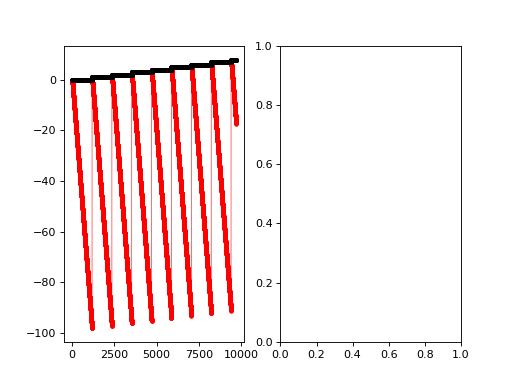

In [861]:
fig, axn = pl.subplots(1,2) #.figure()

ncyc=10
npts = d2*ncyc

ax = axn[0]
ax.plot(proj_az[0:npts], 'r',  marker='.', lw=0.5)
ax.plot(pix[0:npts], 'k',  marker='.', lw=.5)
#ax.plot(ret_az[0:npts], 'b', marker='.', lw=0)

#ax = axn[1]
#ax.scatter(proj_az[0:npts], ret_az[0:npts], marker='.', s=2)


<IPython.core.display.Javascript object>


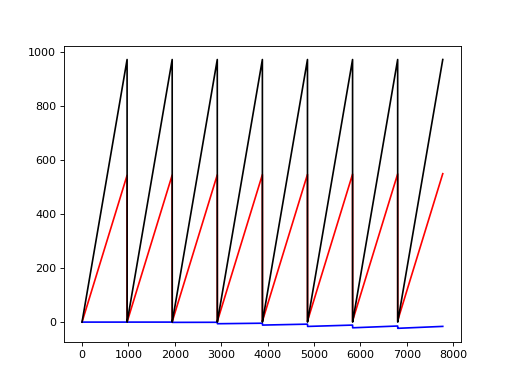

In [724]:
fig, ax = pl.subplots() #.figure()
ncyc=8
ax.plot(proj_el[0:d2*ncyc], 'r') 
ax.plot(ret_el[0:d2*ncyc], 'b')
ax.plot(pix[0:d2*ncyc], 'k')

#ax.invert_yaxis()

<IPython.core.display.Javascript object>


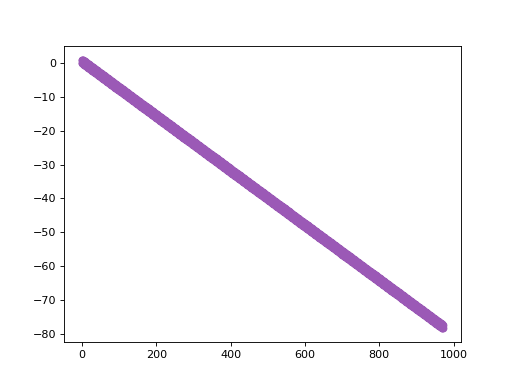

In [601]:
pl.figure()
ncyc=2
pl.scatter(pix[0:d2*ncyc], proj_az[0:d2*ncyc])

In [695]:
# proj_az = np.array([np.dot(np.array((yv, xv)), vhat_az) for xv in np.arange(0, d1) for yv in np.arange(0, d2)])
# proj_el = np.array([np.dot(np.array((yv, xv)), vhat_el) for xv in np.arange(0, d1) for yv in np.arange(0, d2)])
# pix = np.array([yv for xv in np.arange(0, d1) for yv in np.arange(0, d2)])

proj_az = np.array([np.dot(np.array((yv, xv)), vhat_az) for xv in np.arange(0, d1) for yv in np.arange(0, d2)])
proj_el = np.array([np.dot(np.array((yv, xv)), vhat_el) for xv in np.arange(0, d1) for yv in np.arange(0, d2)])
pix = np.array([yv for xv in np.arange(0, d1) for yv in np.arange(0, d2)])


<IPython.core.display.Javascript object>


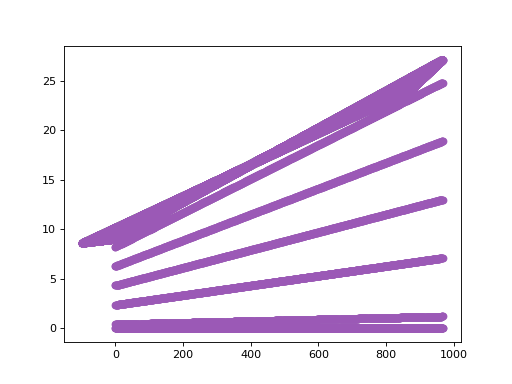

In [751]:
fig, ax = pl.subplots()
ncyc=800
#ax.scatter(proj_az[0:d2*ncyc], ret_az[0:d2*ncyc])
ax.scatter(proj_az, ret_az)

<IPython.core.display.Javascript object>


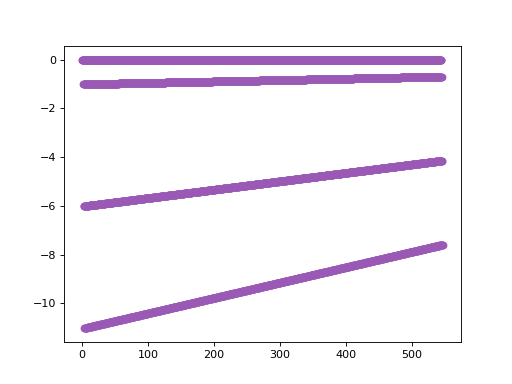

In [716]:
fig, ax = pl.subplots()
ncyc=5
ax.scatter(proj_el[0:d2*ncyc], ret_el[0:d2*ncyc])

In [714]:
proj_el.min()

0.0

<IPython.core.display.Javascript object>


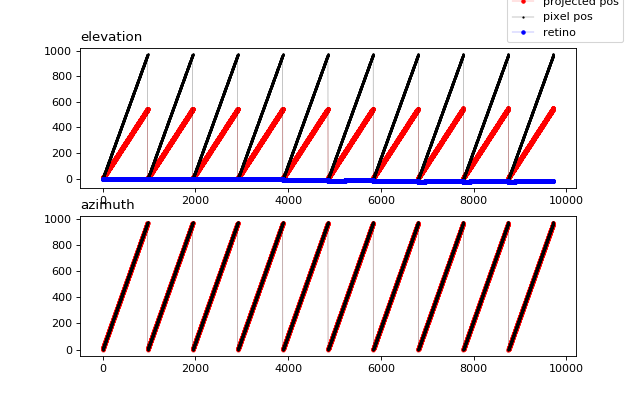

Text(0,1,u'azimuth')

In [703]:

ncyc=10
fig, axn = pl.subplots(2, 1, figsize=(8,5)) #.figure(figsize=(10, 4))
axn[0].plot(proj_el[0:d2*ncyc], marker='.', lw=.2, color='r', label='projected pos')
axn[0].plot(pix[0:d2*ncyc], marker='.', markersize=2, lw=.2, color='k', label='pixel pos')
#axn[0].plot(ret_el[0:d2*ncyc], marker='.', lw=.2, color='b', label='retino')

axn[0].legend(bbox_to_anchor=(.85,1))
axn[0].set_title('elevation', loc='left')

#axn[1].plot(pix[0:d2*ncyc], marker='.', markersize=2, lw=.2, color='k')
axn[1].plot(proj_az[0:d2*ncyc], marker='.', lw=.2, color='r', alpha=0.5)
axn[1].plot(pix[0:d2*ncyc], marker='.', markersize=2, lw=.2, color='k')

axn[1].set_title('azimuth', loc='left')



In [ ]:
(1177, 972)
(1177, 972)

In [538]:
print(xv, yv)

(1176, 971)


In [471]:
coords = np.array([np.array((yv, xv)) for xv in np.arange(0, d1) for yv in np.arange(0, d2)])

(1177, 972)

In [539]:
# Get corresponding smoothed retino points for ^^
retino_az = np.array([img_az[yv, xv] for (xv, yv) in coords]) # in np.arange(0, d1) for yv in np.arange(0, d2)])
retino_el = np.array([img_el[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)])

In [533]:
coords

array([[   0,    0],
       [   1,    0],
       [   2,    0],
       ..., 
       [ 969, 1176],
       [ 970, 1176],
       [ 971, 1176]])

<IPython.core.display.Javascript object>


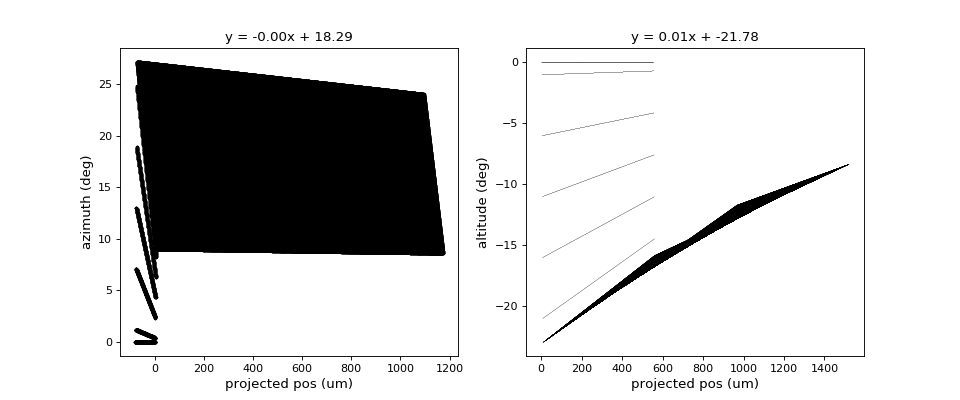

Text(0.5,0,u'projected pos (um)')

In [607]:
fitv_az, regr_az = evalrf.fit_linear_regr(proj_az*1., ret_az, return_regr=True)
fitv_el, regr_el = evalrf.fit_linear_regr(proj_el*1., retino_el, return_regr=True)

# rmse = np.sqrt(skmetrics.mean_squared_error(yv, fitv))
# r2 = skmetrics.r2_score(yv, fitv)
# pearson_p, pearson_r = spstats.pearsonr(xv, yv)

fig, axn = pl.subplots(1,2, figsize=(12, 5))

ax=axn[0]
ax.scatter(proj_az*1., ret_az, marker='.', lw=0, color='k')
linfit_str = 'y = %.2fx + %.2f' % (float(regr_az.coef_), float(regr_az.intercept_)) 
ax.set_title(linfit_str)
ax.set_ylabel('azimuth (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

        
ax=axn[1]
ax.scatter(proj_el*1., retino_el, marker='.', lw=0, color='k', s=.2, alpha=0.5)
linfit_str = 'y = %.2fx + %.2f' % (float(regr_el.coef_), float(regr_el.intercept_)) 
ax.set_title(linfit_str)
ax.set_ylabel('altitude (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)


In [465]:
img_az.shape

(1177, 972)

In [808]:
pixel_size = putils.get_pixel_size()
print(pixel_size)

(2.3, 1.9)


#### Plot direction vector mean 

In [868]:
proj_az = []
proj_el = []
true_pts = []
indices = []
ret_pts_az=[]
ret_pts_el = []

spacing=50

# proj_az1 = np.array([np.dot(np.array((yv, xv)), vhat_az) for xv in np.arange(0, d1) for yv in np.arange(0, d2)])

d1, d2 = grad_az['image'].shape
for xi, xv in enumerate(np.arange(0, d1, spacing)):
    for yi, yv in enumerate(np.arange(0, d2,spacing)):

        # nv = (gdx[xi, yi], gdy[xi, yi])
        ret_v = np.array((img_az[xv, yv], img_el[xv, yv])) #np.array([xv, yv])
        fov_v = np.array((yv, xv))
        
        vproj_az = np.dot(fov_v, vhat_az) # vhat_az *np.dot(nv, vhat)
        vproj_el = np.dot(fov_v, vhat_el) # vhat_el * np.dot(nv, vhat)

        proj_az.append(vproj_az)
        proj_el.append(vproj_el)

        ret_proj_az = np.dot(ret_v, vhat_az)
        ret_proj_el = np.dot(ret_v, vhat_el)
        
        true_pts.append(ret_v)
        indices.append((xv, yv))
        
        ret_pts_az.append(ret_proj_az)
        ret_pts_el.append(ret_proj_el)
        
proj_az = np.array(proj_az)
proj_el = np.array(proj_el)

<IPython.core.display.Javascript object>


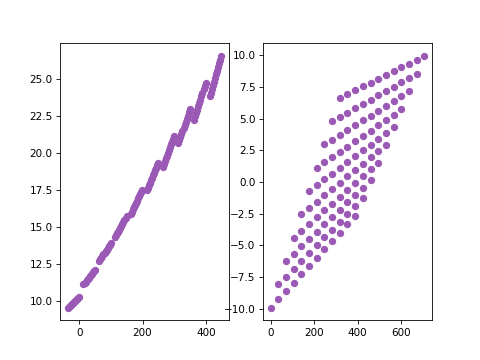

In [869]:
fig, axn = pl.subplots(1,2)

ixs = np.argsort(proj_az)
axn[0].scatter(proj_az, ret_pts_az) #[t[0] for t in true_pts])
#axn[0].invert_yaxis()

axn[1].scatter( proj_el, ret_pts_el) #[t[1] for t in true_pts])
#axn[1].invert_yaxis()



<IPython.core.display.Javascript object>


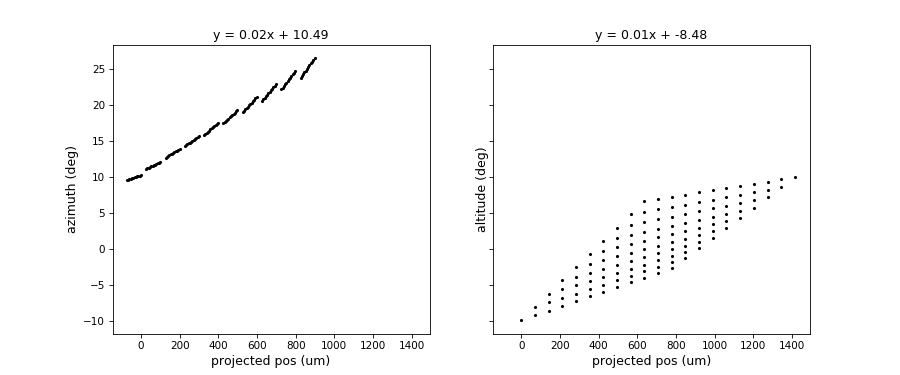

Text(0.5,0,u'projected pos (um)')

In [873]:

fitv_az, regr_az = evalrf.fit_linear_regr(proj_az*2., ret_pts_az, return_regr=True)
fitv_el, regr_el = evalrf.fit_linear_regr(proj_el*2., ret_pts_el, return_regr=True)

# rmse = np.sqrt(skmetrics.mean_squared_error(yv, fitv))
# r2 = skmetrics.r2_score(yv, fitv)
# pearson_p, pearson_r = spstats.pearsonr(xv, yv)

fig, axn = pl.subplots(1,2, figsize=(12, 5), sharex=True, sharey=True)

ax=axn[0]
ax.scatter(proj_az*2., ret_pts_az, marker='.', lw=0, color='k')
linfit_str = 'y = %.2fx + %.2f' % (float(regr_az.coef_), float(regr_az.intercept_)) 
ax.set_title(linfit_str)
ax.set_ylabel('azimuth (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

        
ax=axn[1]
ax.scatter(proj_el*2., ret_pts_el, marker='.', lw=0, color='k')
linfit_str = 'y = %.2fx + %.2f' % (float(regr_el.coef_), float(regr_el.intercept_)) 
ax.set_title(linfit_str)
ax.set_ylabel('altitude (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)


<IPython.core.display.Javascript object>


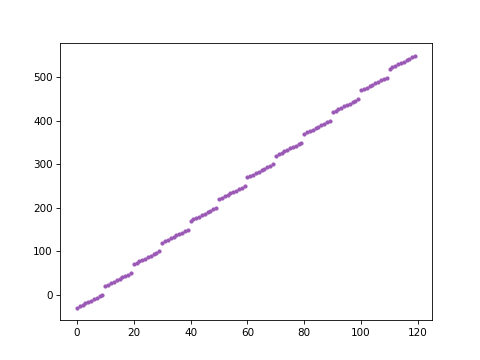

In [629]:
pl.figure()
pl.plot(sorted([t for t in proj_az]), marker='.', lw=0)


<IPython.core.display.Javascript object>


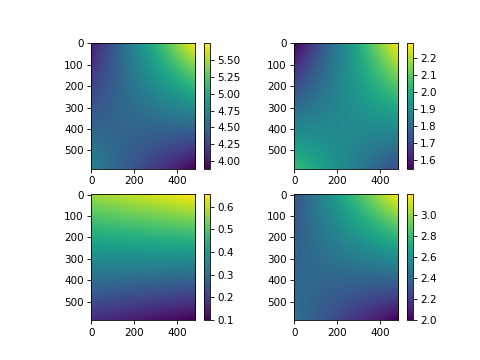

In [487]:
proj_arr_az = np.ones((d1, d2))
true_arr_az = np.ones((d1, d2))
proj_arr_el = np.ones((d1, d2))
true_arr_el = np.ones((d1, d2))

ix = 0
for i in np.arange(0, d1):
    for j in np.arange(0, d2):
        proj_arr_az[i, j] = proj_az[ix][0]
        proj_arr_el[i, j] = proj_el[ix][1]

        true_arr_az[i, j] = true_pts[ix][0]
        true_arr_el[i, j] = true_pts[ix][1]

        ix += 1

fig, axn = pl.subplots(2,2)
im0 = axn[0, 0].imshow(true_arr_az)
pl.colorbar(im0, ax=axn[0,0])
im1 = axn[0, 1].imshow(proj_arr_az)
pl.colorbar(im1, ax=axn[0, 1]) #cax=ax1)

im0 = axn[1, 0].imshow(true_arr_el)
pl.colorbar(im0, ax=axn[1,0])
im1 = axn[1, 1].imshow(proj_arr_el)
pl.colorbar(im1, ax=axn[1, 1]) #cax=ax1)



<IPython.core.display.Javascript object>


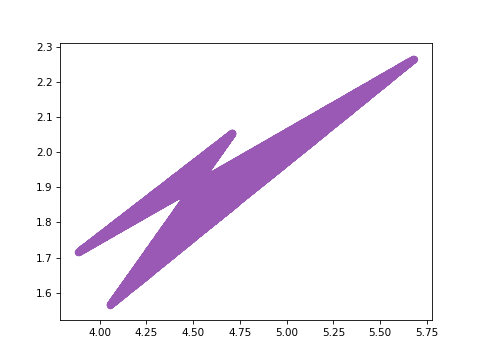

In [466]:
pl.figure()
pl.scatter([p[0] for p in true_pts][10000:], [p[0] for p in proj_pts][10000:])

<IPython.core.display.Javascript object>


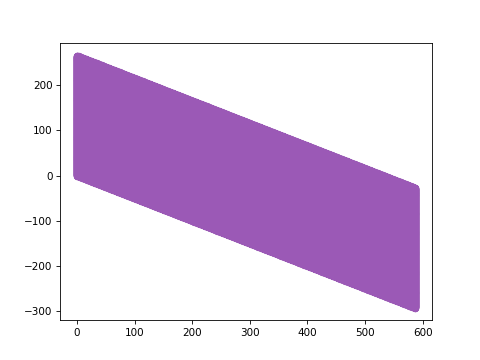

In [429]:
pl.figure()
pl.scatter([p[0] for p in proj_pts], [p[1] for p in true_pts])

In [141]:
print(np.arange(0, y.shape[0], 80))
print(np.arange(0, y.shape[1], 80))


[  0  80 160 240 320 400 480]
[  0  80 160 240 320 400 480 560]


In [139]:
y, x = np.meshgrid(np.arange(0, az_fill.shape[0]), np.arange(0, az_fill.shape[1]))
print(y.shape, x.shape)

((486, 588), (486, 588))


In [138]:
len(x), len(y), az_fill.shape

(486, 486, (588, 486))

In [103]:
np.dot((gdx[5,5], gdy[5,5]), vhat)

0.0015301607814154207

In [104]:
gdx.shape, gdy.shape

((588, 486), (588, 486))

In [108]:
gdx[skip].shape, gdy[skip].shape

((8, 7), (8, 7))

In [109]:
gdx[skip][6,6], gdy[skip][6,6]

(0.00074660832812689648, 0.0031230830186304015)

In [106]:
vhat[1]*r

NameError: name 'r' is not defined

In [ ]:
np.dot([gdx[0][0], gdy[0][0]], vhat)


#### Plot smoothed overlay

In [ ]:
import matplotlib.colors as mcolors


In [135]:
az_fill[~np.isnan(az_fill)].min(), az_fill[~np.isnan(az_fill)].max()

(-0.67404586555207491, 2.7333208703729808)

In [136]:
label = False
transform_fov = True

screen_top = screen['altitude_deg']/2.
screen_right = screen['azimuth_deg']/2.
elev_cutoff = screen_top / screen_right


(-2.9630789025945519, 2.5133787308166133)

# Plot individual

In [1113]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy'

In [1114]:
label = False
label_str = '_labeled' if label else ''
norm = mcolors.Normalize(vmin, vmax)
alpha = 0.7
cmap = cmap_phase

plot_transparent = True
plot_smoothed = True
smooth_fwhm = 25

smooth_str = '_smooth-%i' % smooth_fwhm if plot_smoothed else ''
format_str = '_transparent' if plot_transparent else ''


In [1116]:
# Create smoothed arrays
azim_smoothed = azim_phase.copy()
azim_smoothed[azim_phase==-100] = np.nan

elev_smoothed = elev_phase.copy()
elev_smoothed[elev_phase==-100] = np.nan

#if trace_type == 'neuropil':
azim_smoothed = smooth_neuropil(azim_smoothed, smooth_fwhm)
elev_smoothed = smooth_neuropil(elev_smoothed, smooth_fwhm)

    #azim_smoothed = smooth_array(azim_smoothed, smooth_fwhm, phaseArray=True)
    #elev_smoothed = smooth_array(elev_smoothed, smooth_fwhm, phaseArray=True)
    
if 'zoom1p0x' in fov:
    azim_smoothed = cv2.resize(azim_smoothed, (new_d1, new_d2))
    elev_smoothed = cv2.resize(elev_smoothed, (new_d1, new_d2))

<IPython.core.display.Javascript object>


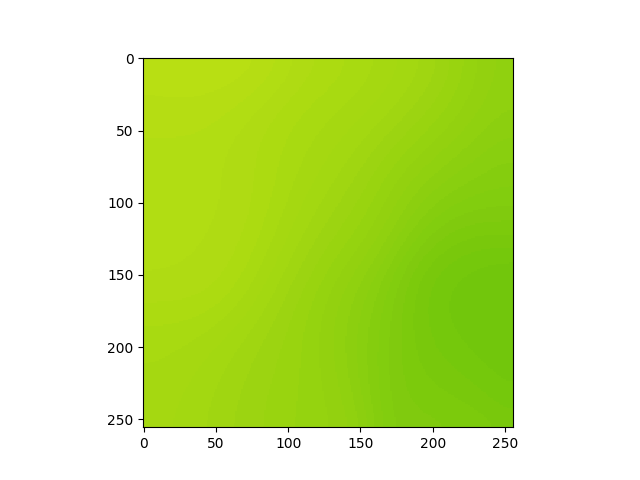

In [1117]:
pl.figure()
pl.imshow(elev_smoothed, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)

<IPython.core.display.Javascript object>


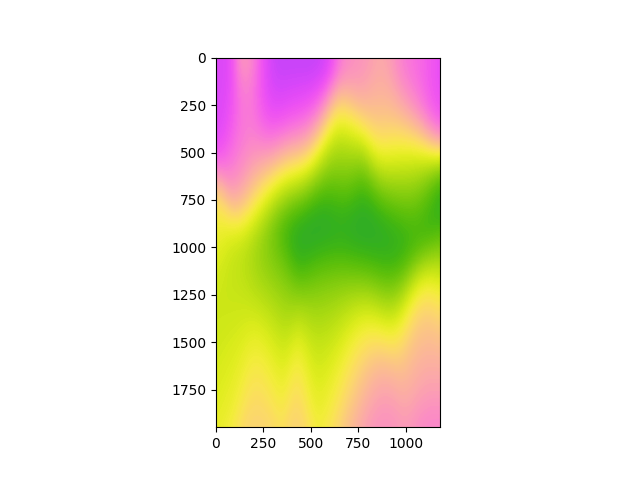

In [169]:
pl.figure()
pl.imshow(azim_smoothed, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)

In [170]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/figures/caiman-examples'

In [171]:
def plot_phase_map(array, zimg=None, cmap='hsv', vmin=-np.pi, vmax=np.pi, alpha=0.7,
                  plot_transparent=True, plot_smoothed=False, ax=None):
    
    norm = mcolors.Normalize(vmin, vmax)
    
    if ax is None:
        fig, ax = pl.subplots()

    if plot_transparent:
        if zimg is not None:
            ax.imshow(zimg, cmap='gray', alpha=0); ax.axis('off')
        ax.patch.set_visible(0)
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    else:
        ax.patch.set_visible(0)
        if zimg is not None:
            ax.imshow(zimg, cmap='gray'); ax.axis('off');
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    return ax

<IPython.core.display.Javascript object>


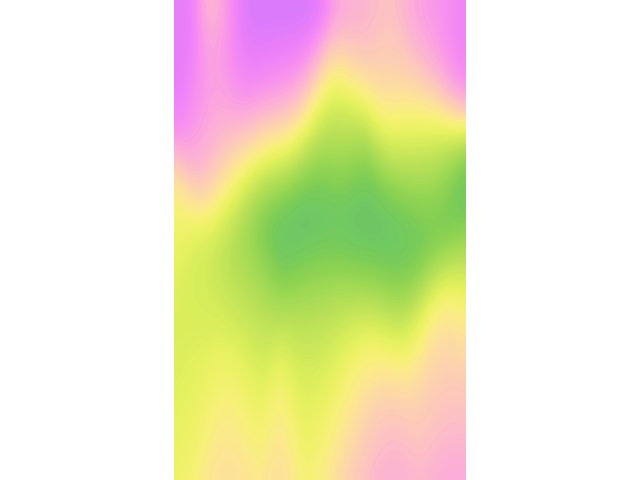

neuropil_absolute-azimuth_filter-allconds-magthr0.01_443cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [172]:

condition = 'azimuth'
if condition == 'azimuth':
    plot_arr = azim_smoothed.copy() if plot_smoothed else azim_phase_mask.copy()
elif condition == 'elevation':
    plot_arr = elev_smoothed.copy() if plot_smoothed else elev_phase_mask.copy()

fig, ax = pl.subplots()
ax = plot_phase_map(plot_arr, zimg=zimg, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha,
                   plot_transparent=plot_transparent, plot_smoothed=plot_smoothed, ax=ax)

if label:
    for roi in tmp_rlist:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')
    label_figure(fig, data_identifier)

if filter_by_mag:
    figname = '%s_absolute-%s_filter-allconds-magthr%.2f_%icells' % (trace_type, condition, mag_thr, len(roi_list))
else:
    figname = '%s_absolute-%s' % (trace_type, condition)
figname = '%s_%s_%s%s' % (figname, skey, format_str, smooth_str)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(figname)

<IPython.core.display.Javascript object>


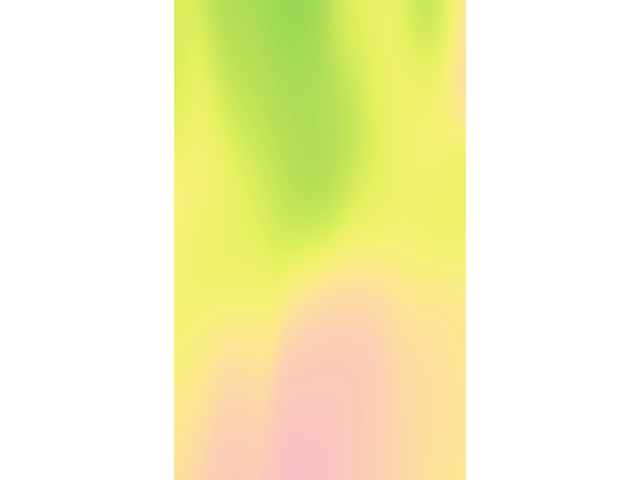

neuropil_absolute-elevation_filter-allconds-magthr0.01_443cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [173]:

condition = 'elevation'
if condition == 'azimuth':
    plot_arr = azim_smoothed.copy() if plot_smoothed else azim_phase_mask.copy()
elif condition == 'elevation':
    plot_arr = elev_smoothed.copy() if plot_smoothed else elev_phase_mask.copy()

fig, ax = pl.subplots()
ax = plot_phase_map(plot_arr, zimg=zimg, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha,
                   plot_transparent=plot_transparent, plot_smoothed=plot_smoothed, ax=ax)

if label:
    for roi in tmp_rlist:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')
    label_figure(fig, data_identifier)

if filter_by_mag:
    figname = '%s_absolute-%s_filter-allconds-magthr%.2f_%icells' % (trace_type, condition, mag_thr, len(roi_list))
else:
    figname = '%s_absolute-%s' % (trace_type, condition)
figname = '%s_%s_%s%s' % (figname, skey, format_str, smooth_str)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(figname)

<IPython.core.display.Javascript object>


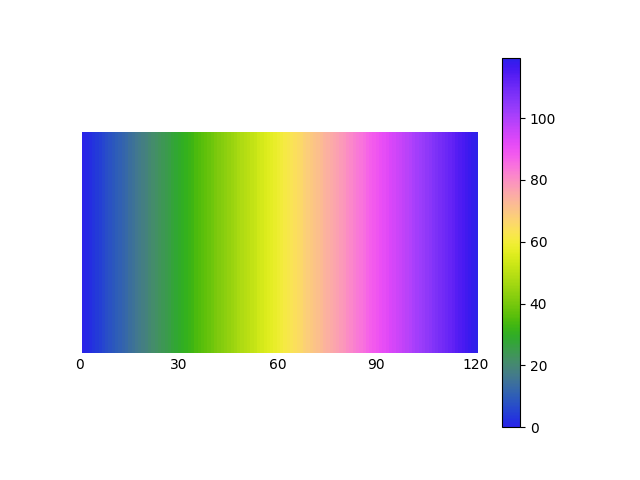

cond2-pos_colorwheel_LEGEND_abs


In [382]:
fig, ax = pl.subplots()
im = ax.imshow(az_screen, cmap=cmap_phase)
#ax.invert_xaxis()
pl.colorbar(im)
ax.set_xticks(np.linspace(0, int(round(screen_x)), 5))
ax.set_xticklabels([int(round(i)) for i in np.linspace(0, int(round(screen_x)), 5)][::-1])

#spos1, epos1 = pos1_deg[0], pos1_deg[-1]
#spos2, epos2 = pos2_deg[0], pos2_deg[-1]

#ax.axvline(x=screen_x-spos1, c='w')
#ax.axvline(x=screen_x-epos1, c='w')

#ax.axvline(x=screen_x-spos2, c='w')
#ax.axvline(x=screen_x-epos2, c='w')

ax.set_yticks([])
ax.set_yticklabels([])
ax.tick_params(axis='x', length=0)
ax.set_frame_on(False)

ax.set_xlim(ax.get_xlim()[::-1])


figname = 'cond2-pos_%s_LEGEND_abs' % (colormap)

pl.savefig(os.path.join(retinodir, '%s.png' % figname))

print figname

# Save legends

<IPython.core.display.Javascript object>


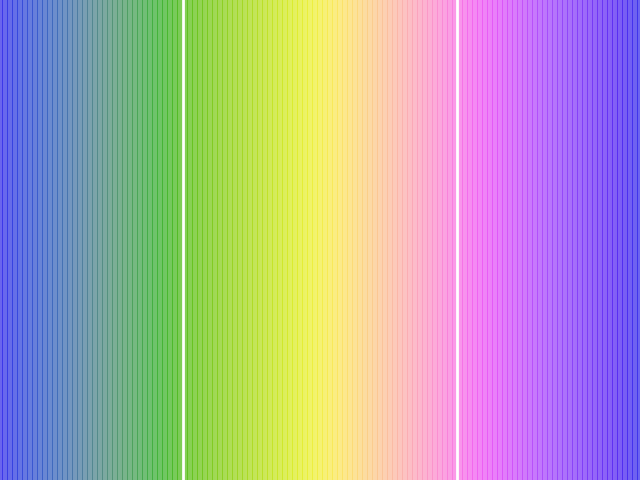

In [117]:
fig = pl.figure()

# Colorbar axes are from (0, 1) -- need to reset fraction cutoff between 0, 1...
elev_min = elev_cutoff/2.
elev_max = 1- elev_cutoff/2.

cbar1_orientation='horizontal'
cbar1_axes = [0, 0, 1, 1] #[0.31, 0.78, 0.1, 0.05]

cbaxes1 = fig.add_axes(cbar1_axes) 
cb1 = pl.colorbar(im1, cax=cbaxes1, orientation=cbar1_orientation)  
cb1.ax.axis('off')
cb1.outline.set_visible(False)
cb1.ax.axvline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb1.ax.axvline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')

pl.savefig(os.path.join(outdir, 'legend_absolute-azimuth.png')) #% (figname, label_str)))


<IPython.core.display.Javascript object>


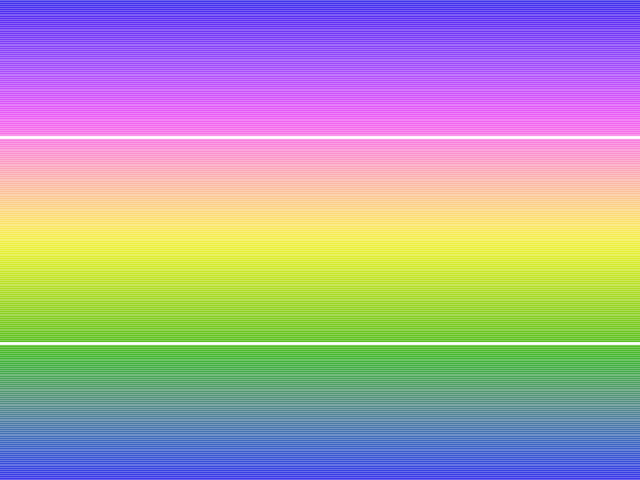

corrected_absolute-elevation_filter-allconds-magthr0.01_174cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [118]:
fig = pl.figure()

cbar2_orientation='vertical'
cbar2_axes = [0, 0, 1, 1] #[0.79, 0.78, 0.1, 0.05]

cbaxes2 = fig.add_axes(cbar2_axes) 
cb2 = pl.colorbar(im2, cax=cbaxes2, orientation=cbar2_orientation)
#cb2.ax.set_ylim(-vmax*elev_cutoff, vmax*elev_cutoff)
cb2.ax.axhline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axhline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axis('off')
cb2.outline.set_visible(False)


#label_figure(fig, data_identifier)
pl.savefig(os.path.join(outdir, 'legend_absolute-elevation.png')) #% (figname, label_str)))

print(figname)